In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import *

# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

--ip=127.0.0.1


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [4]:
parent_dir = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [5]:

df_train = pd.read_csv(os.path.join(parent_dir, 'Data\AugmentedData\english_train_augmented.csv'))
df_dev = pd.read_csv(os.path.join(parent_dir, 'Data\PreprocessedData\english_dev_preprocess.csv'))
df_test = pd.read_csv(os.path.join(parent_dir, 'Data\PreprocessedData\english_test_preprocess.csv'))

In [6]:
df_train = df_train[['augmented_text', 'label']]
df_dev = df_dev[['preprocessed_text', 'label']]
df_test = df_test[['preprocessed_text', 'label']]

In [7]:
label_replacement = {
    'Hope_speech': 0,
    'Non_hope_speech': 1,
    'not-English': 2,
}

df_train['label'] = df_train['label'].replace(label_replacement)
df_test['label'] = df_test['label'].replace(label_replacement)
df_dev['label'] = df_dev['label'].replace(label_replacement)

# Drop rows with label 2
df_train = df_train[df_train['label'] != 2]
df_test = df_test[df_test['label'] != 2]
df_dev = df_dev[df_dev['label'] != 2]

In [8]:
X_train, y_train = df_train['augmented_text'].to_numpy(), df_train['label'].to_numpy()
X_dev, y_dev = df_dev['preprocessed_text'].to_numpy(), df_dev['label'].to_numpy()
X_test, y_test = df_test['preprocessed_text'].to_numpy(), df_test['label'].to_numpy()

In [9]:
t = Tokenizer()
t.fit_on_texts(X_train)

In [10]:
encoded_train = t.texts_to_sequences(X_train)
encoded_dev = t.texts_to_sequences(X_dev)
encoded_test = t.texts_to_sequences(X_test)

In [11]:
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_dev = pad_sequences(encoded_dev, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

In [12]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(SimpleRNN(24, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 24)             521064    
                                                                 
 simple_rnn (SimpleRNN)      (None, 24)                1176      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 522,265
Trainable params: 522,265
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# fit the model
history = model.fit(
    x=padded_train,
    y=y_train,
    epochs=100,
    validation_data=(padded_dev, y_dev), verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100
1324/1324 [==============================] - 5s 3ms/step - loss: 0.4512 - accuracy: 0.7815 - val_loss: 0.3925 - val_accuracy: 0.8363
Epoch 2/100
1324/1324 [==============================] - 4s 3ms/step - loss: 0.2877 - accuracy: 0.8816 - val_loss: 0.4019 - val_accuracy: 0.8321
Epoch 3/100
1324/1324 [==============================] - 4s 3ms/step - loss: 0.2254 - accuracy: 0.9097 - val_loss: 0.3964 - val_accuracy: 0.8388
Epoch 4/100
1324/1324 [==============================] - 4s 3ms/step - loss: 0.1944 - accuracy: 0.9242 - val_loss: 0.3999 - val_accuracy: 0.8476
Epoch 4: early stopping


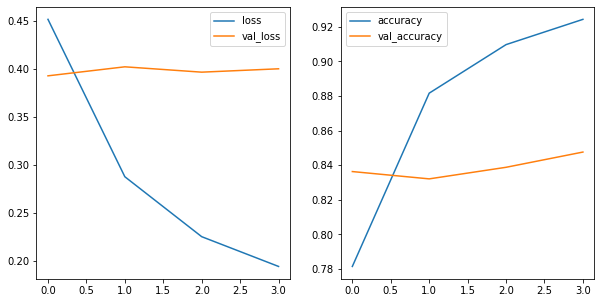

In [14]:
# Plot loss, accuracy, val_loss, val_accuracy
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()
plot_history(history)

In [15]:
train_preds = model.predict(padded_train)
dev_preds = model.predict(padded_dev)
test_preds = model.predict(padded_test)

train_preds = np.where(train_preds > 0.5, 1, 0)
dev_preds = np.where(dev_preds > 0.5, 1, 0)
test_preds = np.where(test_preds > 0.5, 1, 0)

train_preds = train_preds.flatten()
dev_preds = dev_preds.flatten()
test_preds = test_preds.flatten()

89/89 [==============================] - 0s 1ms/step


In [16]:
computeAllScores(train_preds, dev_preds, test_preds, True, True)

Accuracy Train:  0.9402502360717658
Accuracy Dev:  0.847588877155931
Accuracy Test:  0.8462891311994372
Weighted F1 Train:  0.940251880814837
Weighted F1 Dev:  0.8621166742111145
Weighted F1 Test:  0.8643340555834584
Macro F1 Train:  0.9402321438979846
Macro F1 Dev:  0.6468240946255897
Macro F1 Test:  0.6382417677130768
Micro F1 Train:  0.9402502360717658
Micro F1 Dev:  0.847588877155931
Micro F1 Test:  0.8462891311994372
Weighted Recall Train:  0.9402502360717658
Weighted Recall Dev:  0.847588877155931
Weighted Recall Test:  0.8462891311994372
Macro Recall Train:  0.9402587350401332
Macro Recall Dev:  0.6872645856707805
Macro Recall Test:  0.6898380254531431
Micro Recall Train:  0.9402502360717658
Micro Recall Dev:  0.847588877155931
Micro Recall Test:  0.8462891311994372
Confusion Matrix Train: 
[[20283  1299]
 [ 1232 19546]]
Confusion Matrix Dev: 
[[ 133  139]
 [ 294 2275]]
Confusion Matrix Test: 
[[ 125  125]
 [ 312 2281]]
